In [1]:
import sqlite3
import pandas as pd
import gzip
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import matplotlib.pyplot as plt

from nltk.stem import SnowballStemmer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, RobustScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')


In [2]:
# Connect to the SQLite database
conn = sqlite3.connect('data/shop_database.db')

# Read personal_data table
personal_data_query = "SELECT * FROM personal_data"
personal_data = pd.read_sql_query(personal_data_query, conn)

# Read personal_data_coeffs table
personal_data_coeffs_query = "SELECT * FROM personal_data_coeffs"
personal_data_coeffs = pd.read_sql_query(personal_data_coeffs_query, conn)

# Read purchases table
purchases_query = "SELECT * FROM purchases"
purchases = pd.read_sql_query(purchases_query, conn)

# Close the database connection
conn.close()

In [3]:
# Read and decompress personal_data.csv.gz
with gzip.open('data/personal_data.csv.gz', 'rt') as f:
    lost_data = pd.read_csv(f)

# Add lost data to personal_data
personal_data = pd.concat([personal_data, lost_data])

dfs = [personal_data, personal_data_coeffs, purchases]

# Print the shape of each dataframe
for df in dfs:
    print(df.shape)

(104989, 6)
(104989, 5)
(786260, 7)


In [4]:
# merge all dataframes
data = pd.merge(purchases, personal_data, on='id', how='left')
data = pd.merge(data, personal_data_coeffs, on='id', how='left')

# 1. Exploratory Data Analysis

## 1.1 Overview

- id: Unique identifier for each client.

- product: Name of the purchased product.

- colour: Colour of the purchased product.

- cost: Cost of the product.

- product_sex: Gender of potential buyers of the product.

- base_sale: Availability of a discount at the time of purchase.

- dt: Date of the purchase.

- gender: Gender of the client. Target variable.

- age: Age of the client.

- education: Education level of the client.

- city: City of residence of the client.

- country: Country of residence of the client.

- personal_coef, lbt_coef, ac_coef, sm_coef: Coefficients calculated for each client based on some closed scheme.

In [5]:
data.head()

,id,product,colour,cost,product_sex,base_sale,dt,gender,age,education,city,country,lbt_coef,ac_coef,sm_coef,personal_coef
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7,0.0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072
1,0,Стол Outventure,зелёный,1499,NaN,0,37,0.0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,NaN,0,37,0.0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13,NaN,31,среднее,1134,32,7.764766,-0.030225,0.794720,0.4304
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,NaN,0,27,NaN,31,среднее,1134,32,7.764766,-0.030225,0.794720,0.4304


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 786260 entries, 0 to 786259
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             786260 non-null  int64  
 1   product        786260 non-null  object 
 2   colour         666736 non-null  object 
 3   cost           786260 non-null  int64  
 4   product_sex    471548 non-null  float64
 5   base_sale      786260 non-null  int64  
 6   dt             786260 non-null  int64  
 7   gender         669956 non-null  float64
 8   age            786260 non-null  int64  
 9   education      786260 non-null  object 
 10  city           786260 non-null  int64  
 11  country        786260 non-null  int64  
 12  lbt_coef       786260 non-null  float64
 13  ac_coef        786260 non-null  float64
 14  sm_coef        786260 non-null  float64
 15  personal_coef  786260 non-null  float64
dtypes: float64(6), int64(7), object(3)
memory usage: 102.0+ MB


## 1.2 Missing Values

### 1.2.1 Colour
We will replace the missing values with 'неизвестно' since we don't know the colour of the product.

In [7]:
data['colour'].fillna('неизвестно', inplace=True)

### 1.2.2 Product_sex
Some product names contain a separation between boys and girls, while others seem to be genderless.
We can use this information to create a feature that will tell us whether the buyer has kids and their kids' gender, but this feature seems to be irrelevant in our case. So, we'll replace missing values with 2.

In [8]:
data[data['product_sex'].isnull()].head(20)

,id,product,colour,cost,product_sex,base_sale,dt,gender,age,education,city,country,lbt_coef,ac_coef,sm_coef,personal_coef
1,0,Стол Outventure,зелёный,1499,NaN,0,37,0.0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,NaN,0,37,0.0,36,среднее,1201,32,5.078678,-0.307147,0.959027,0.5072
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,NaN,0,27,NaN,31,среднее,1134,32,7.764766,-0.030225,0.794720,0.4304
7,4,Роликовые коньки детские Roces Orlando III,черный/розовый,9199,NaN,0,0,0.0,35,среднее,1134,32,4.569378,0.063693,0.820892,0.5072
8,4,Шлем FILA NRK FUN,белый,4999,NaN,0,0,0.0,35,среднее,1134,32,4.569378,0.063693,0.820892,0.5072
9,4,Роликовые коньки детские Roces Yuma TIF,мультицвет,6999,NaN,0,1,0.0,35,среднее,1134,32,4.569378,0.063693,0.820892,0.5072
10,4,Набор защиты из 3-х предметов детский Reaction...,белый/серый,999,NaN,0,1,0.0,35,среднее,1134,32,4.569378,0.063693,0.820892,0.5072
11,4,Шлем для девочек Reaction Urban,розовый,1499,NaN,0,2,0.0,35,среднее,1134,32,4.569378,0.063693,0.820892,0.5072
12,4,Роликовые коньки детские раздвижные Reaction R...,серый/розовый,4399,NaN,0,2,0.0,35,среднее,1134,32,4.569378,0.063693,0.820892,0.5072
13,4,Куртка утепленная для девочек Outventure,неизвестно,2999,NaN,0,32,0.0,35,среднее,1134,32,4.569378,0.063693,0.820892,0.5072


In [9]:
# Replace missing values with '2'
data['product_sex'].replace(to_replace = np.nan, value = 2, inplace = True)

### 1.2.2 Gender
We will sepparate data on two parts: data with missing values and data without missing values. Then we will train a model to predict the missing values.

In [10]:
def divide_df(data):
    return data[data['gender'].notnull()].reset_index(drop=True), data[data['gender'].isnull()].reset_index(drop=True)

def concat_df(train_data, test_data):
    return pd.concat([train_data, test_data]).reset_index(drop=True)

In [11]:
# Create train and test sets
df_train, df_test = divide_df(data)

## 1.3 Correlations

In [12]:
df_train_corr = df_train.drop(['id'], axis=1).corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)
df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index)

df_test_corr = df_test.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_test_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_test_corr.drop(df_test_corr.iloc[1::2].index, inplace=True)
df_test_corr_nd = df_test_corr.drop(df_test_corr[df_test_corr['Correlation Coefficient'] == 1.0].index)

In [13]:
# Training set high correlations
corr = df_train_corr_nd['Correlation Coefficient'] > 0.1
df_train_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
12,lbt_coef,gender,0.935563
14,city,ac_coef,0.836653
16,personal_coef,gender,0.622265
18,lbt_coef,personal_coef,0.497286
20,personal_coef,age,0.287303
22,product_sex,gender,0.228065
24,product_sex,base_sale,0.206439
26,product_sex,lbt_coef,0.201817
28,sm_coef,personal_coef,0.200171
30,lbt_coef,age,0.159814


In [14]:
# Test set high correlations
corr = df_test_corr_nd['Correlation Coefficient'] > 0.1
df_test_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
12,city,ac_coef,0.827316
14,lbt_coef,personal_coef,0.466166
16,personal_coef,age,0.325152
18,sm_coef,personal_coef,0.224812
20,product_sex,base_sale,0.208014
22,product_sex,lbt_coef,0.201768
24,lbt_coef,age,0.144671
26,dt,base_sale,0.131626
28,personal_coef,product_sex,0.129801
30,cost,base_sale,0.120903


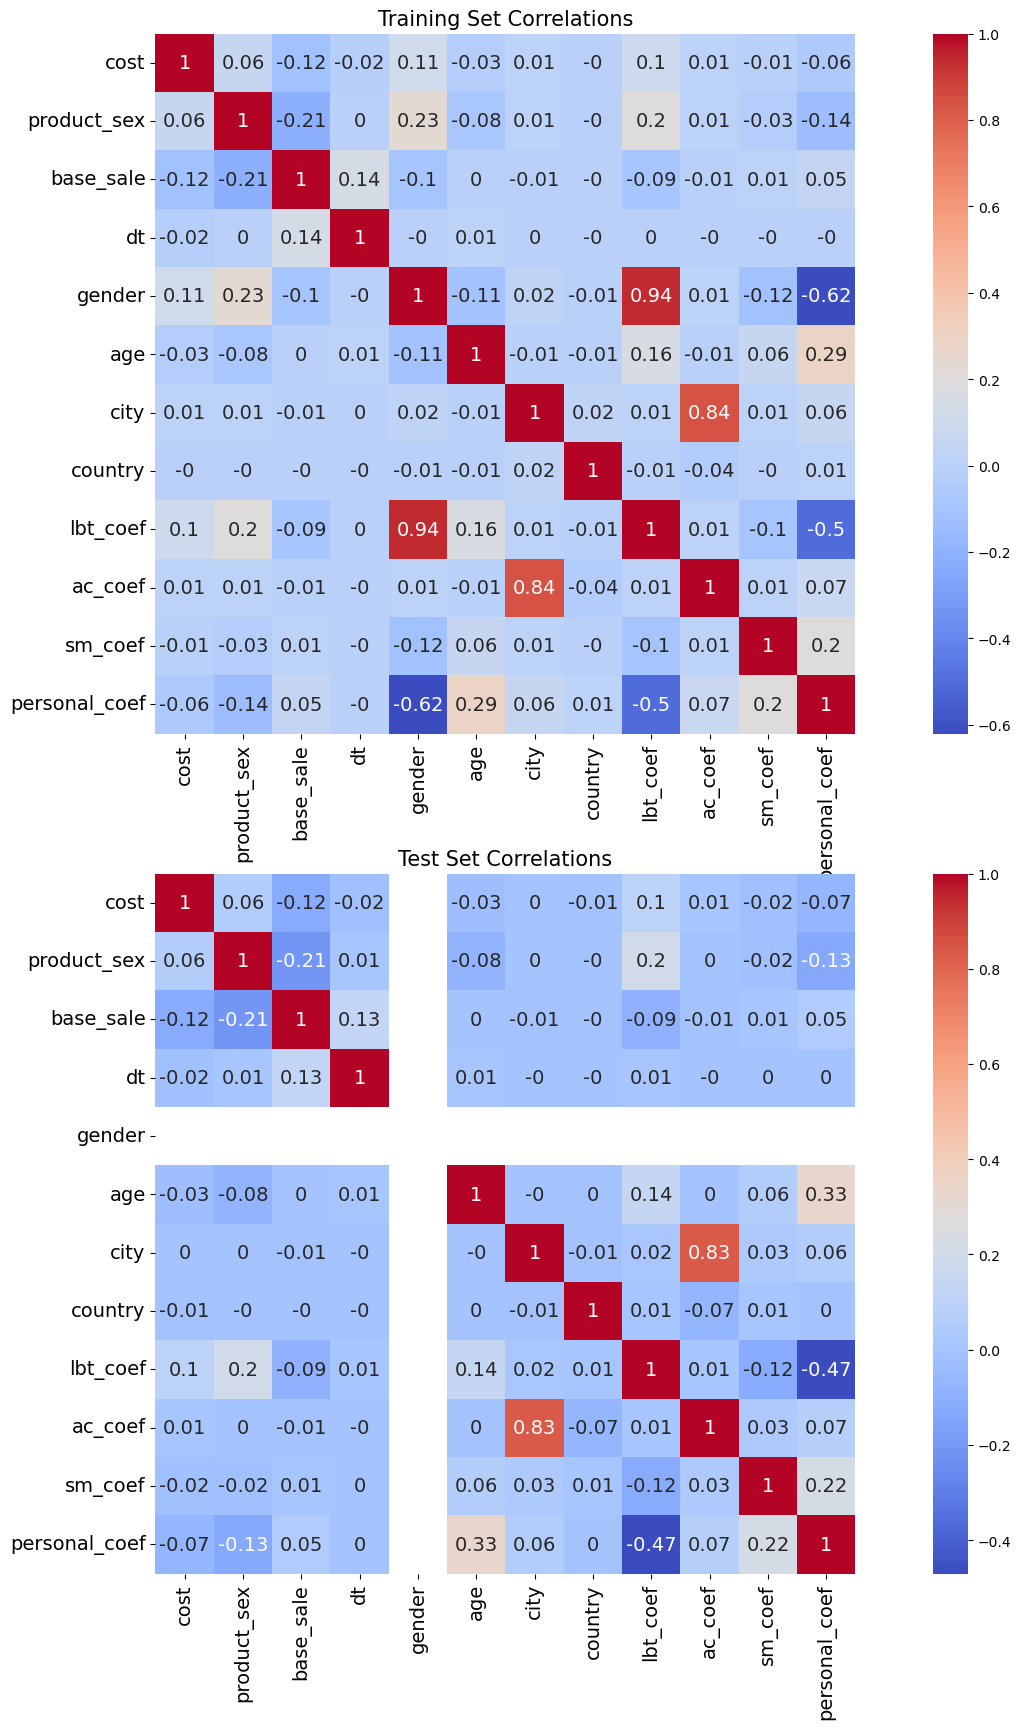

In [15]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))

sns.heatmap(round(df_train.drop(['id'], axis=1).corr(), 2), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})
sns.heatmap(round(df_test.drop(['id'], axis=1).corr(), 2), ax=axs[1], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})

for i in range(2):    
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)
    
axs[0].set_title('Training Set Correlations', size=15)
axs[1].set_title('Test Set Correlations', size=15)

plt.show()

## 1.4 Target Distribution

### 1.4.1 Continuous Features

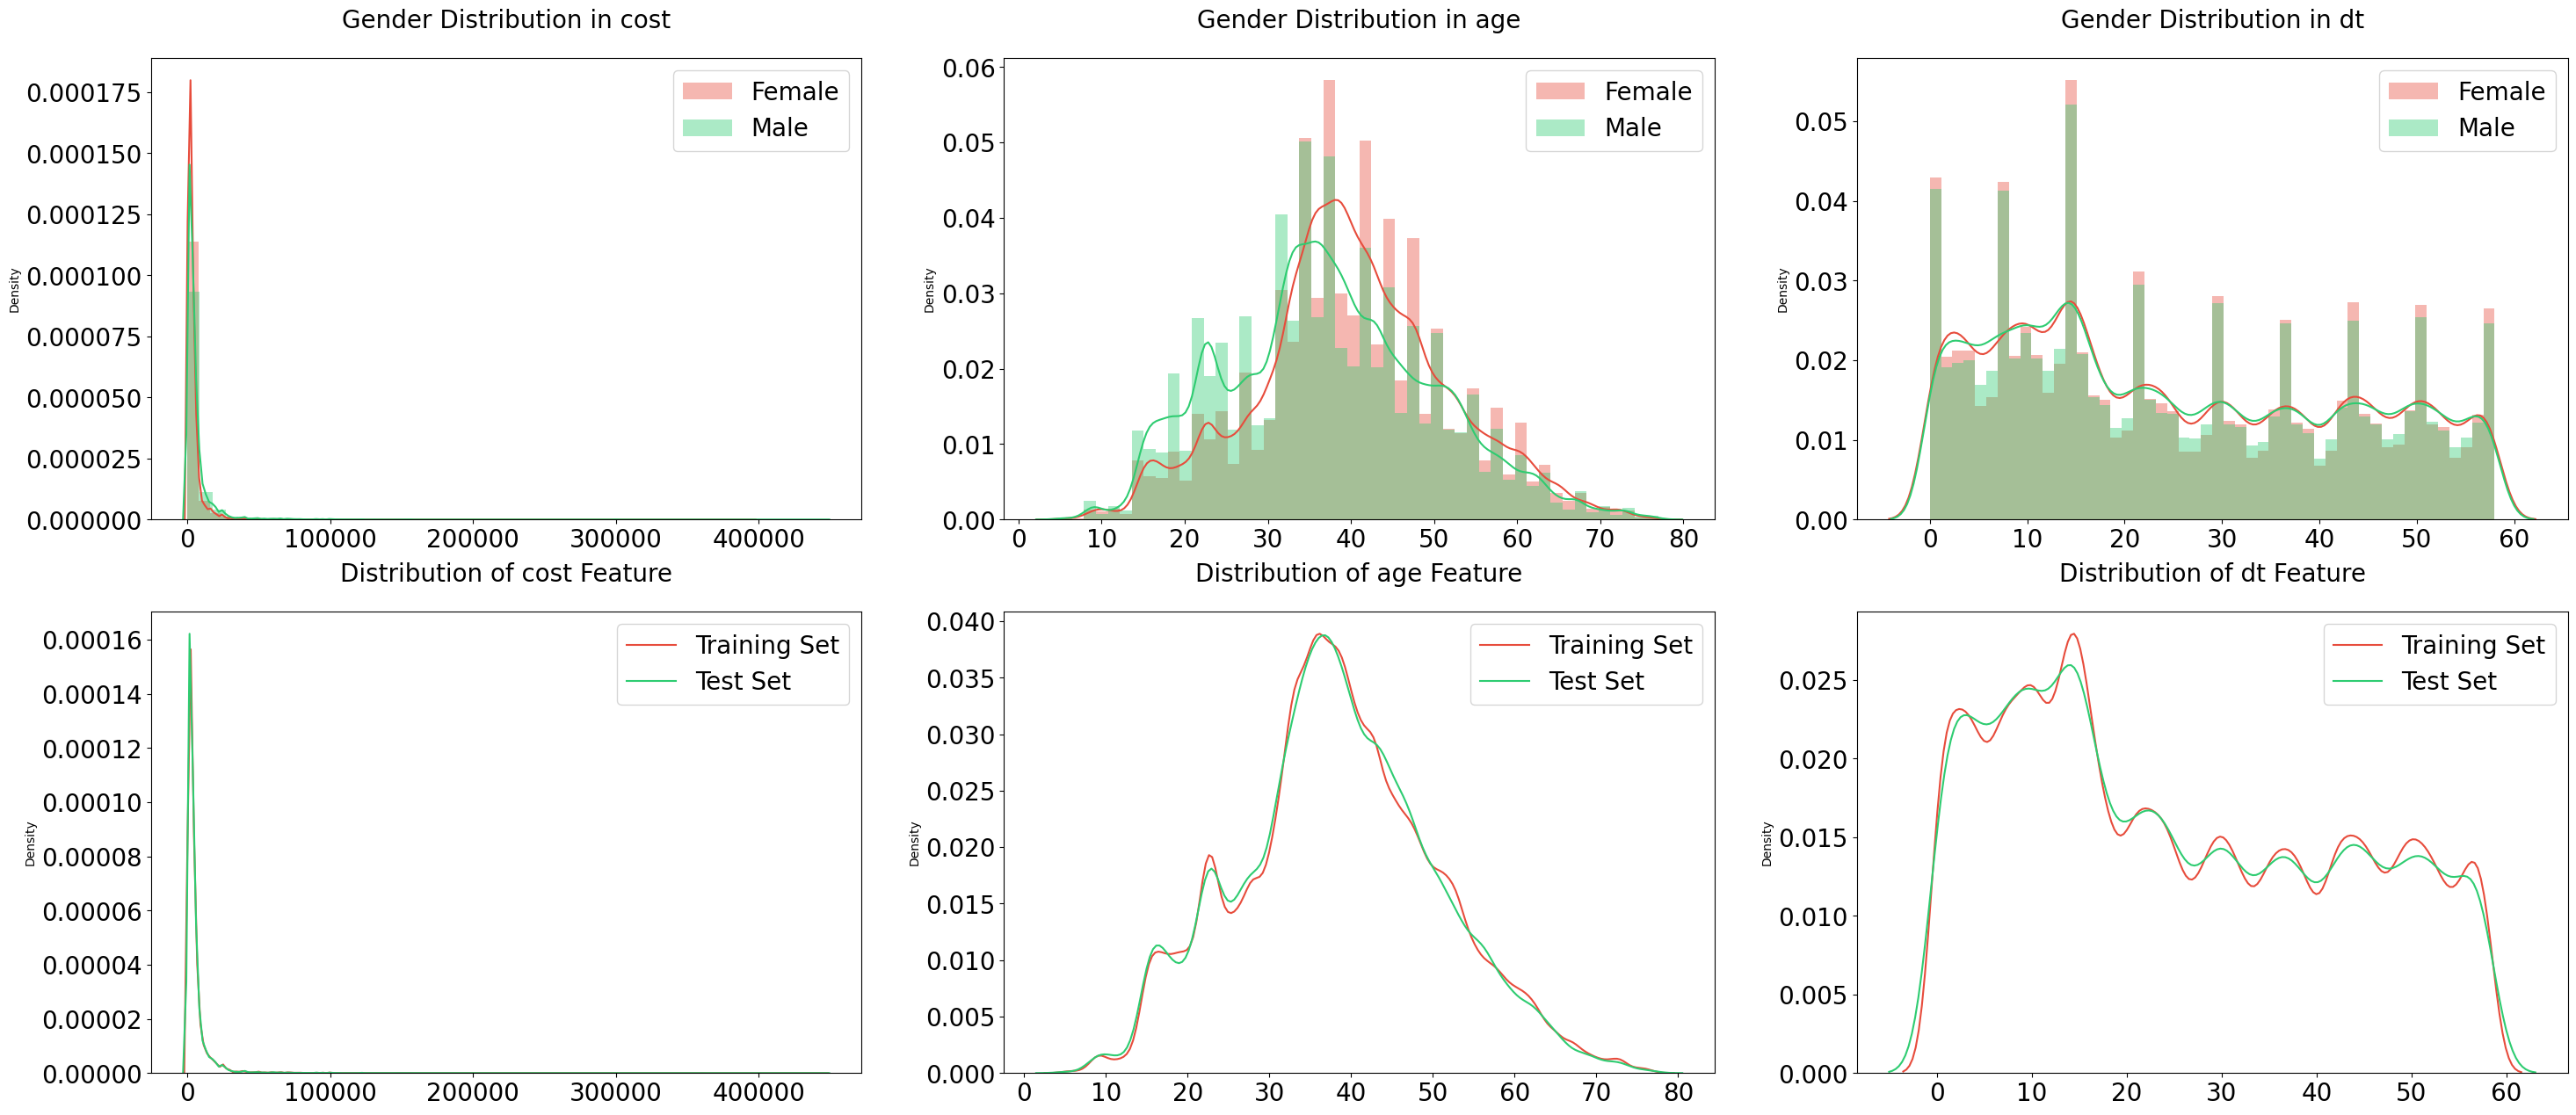

In [16]:
def plot_distributions(df, feature, male, axs):
    # Gender distribution in feature
    sns.distplot(df[~male][feature], label='Female', hist=True, color='#e74c3c', ax=axs[0])
    sns.distplot(df[male][feature], label='Male', hist=True, color='#2ecc71', ax=axs[0])

    # Distribution of feature in dataset
    sns.distplot(df[feature], label='Training Set', hist=False, color='#e74c3c', ax=axs[1])
    sns.distplot(df_test[feature], label='Test Set', hist=False, color='#2ecc71', ax=axs[1])

    axs[0].set_xlabel('')
    axs[1].set_xlabel('')

    for j in range(2):
        axs[j].tick_params(axis='x', labelsize=20)
        axs[j].tick_params(axis='y', labelsize=20)

    axs[0].legend(loc='upper right', prop={'size': 20})
    axs[1].legend(loc='upper right', prop={'size': 20})

    axs[0].set_title('Gender Distribution in {}'.format(feature), size=20, y=1.05)
    axs[1].set_title('Distribution of {} Feature'.format(feature), size=20, y=1.05)

cont_features = ['cost', 'age', 'dt']
male = df_train['gender'] == 1

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(20, 15))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):
    plot_distributions(df_train, feature, male, axs[:, i])

plt.show()


### 1.3.2 Categorical Features

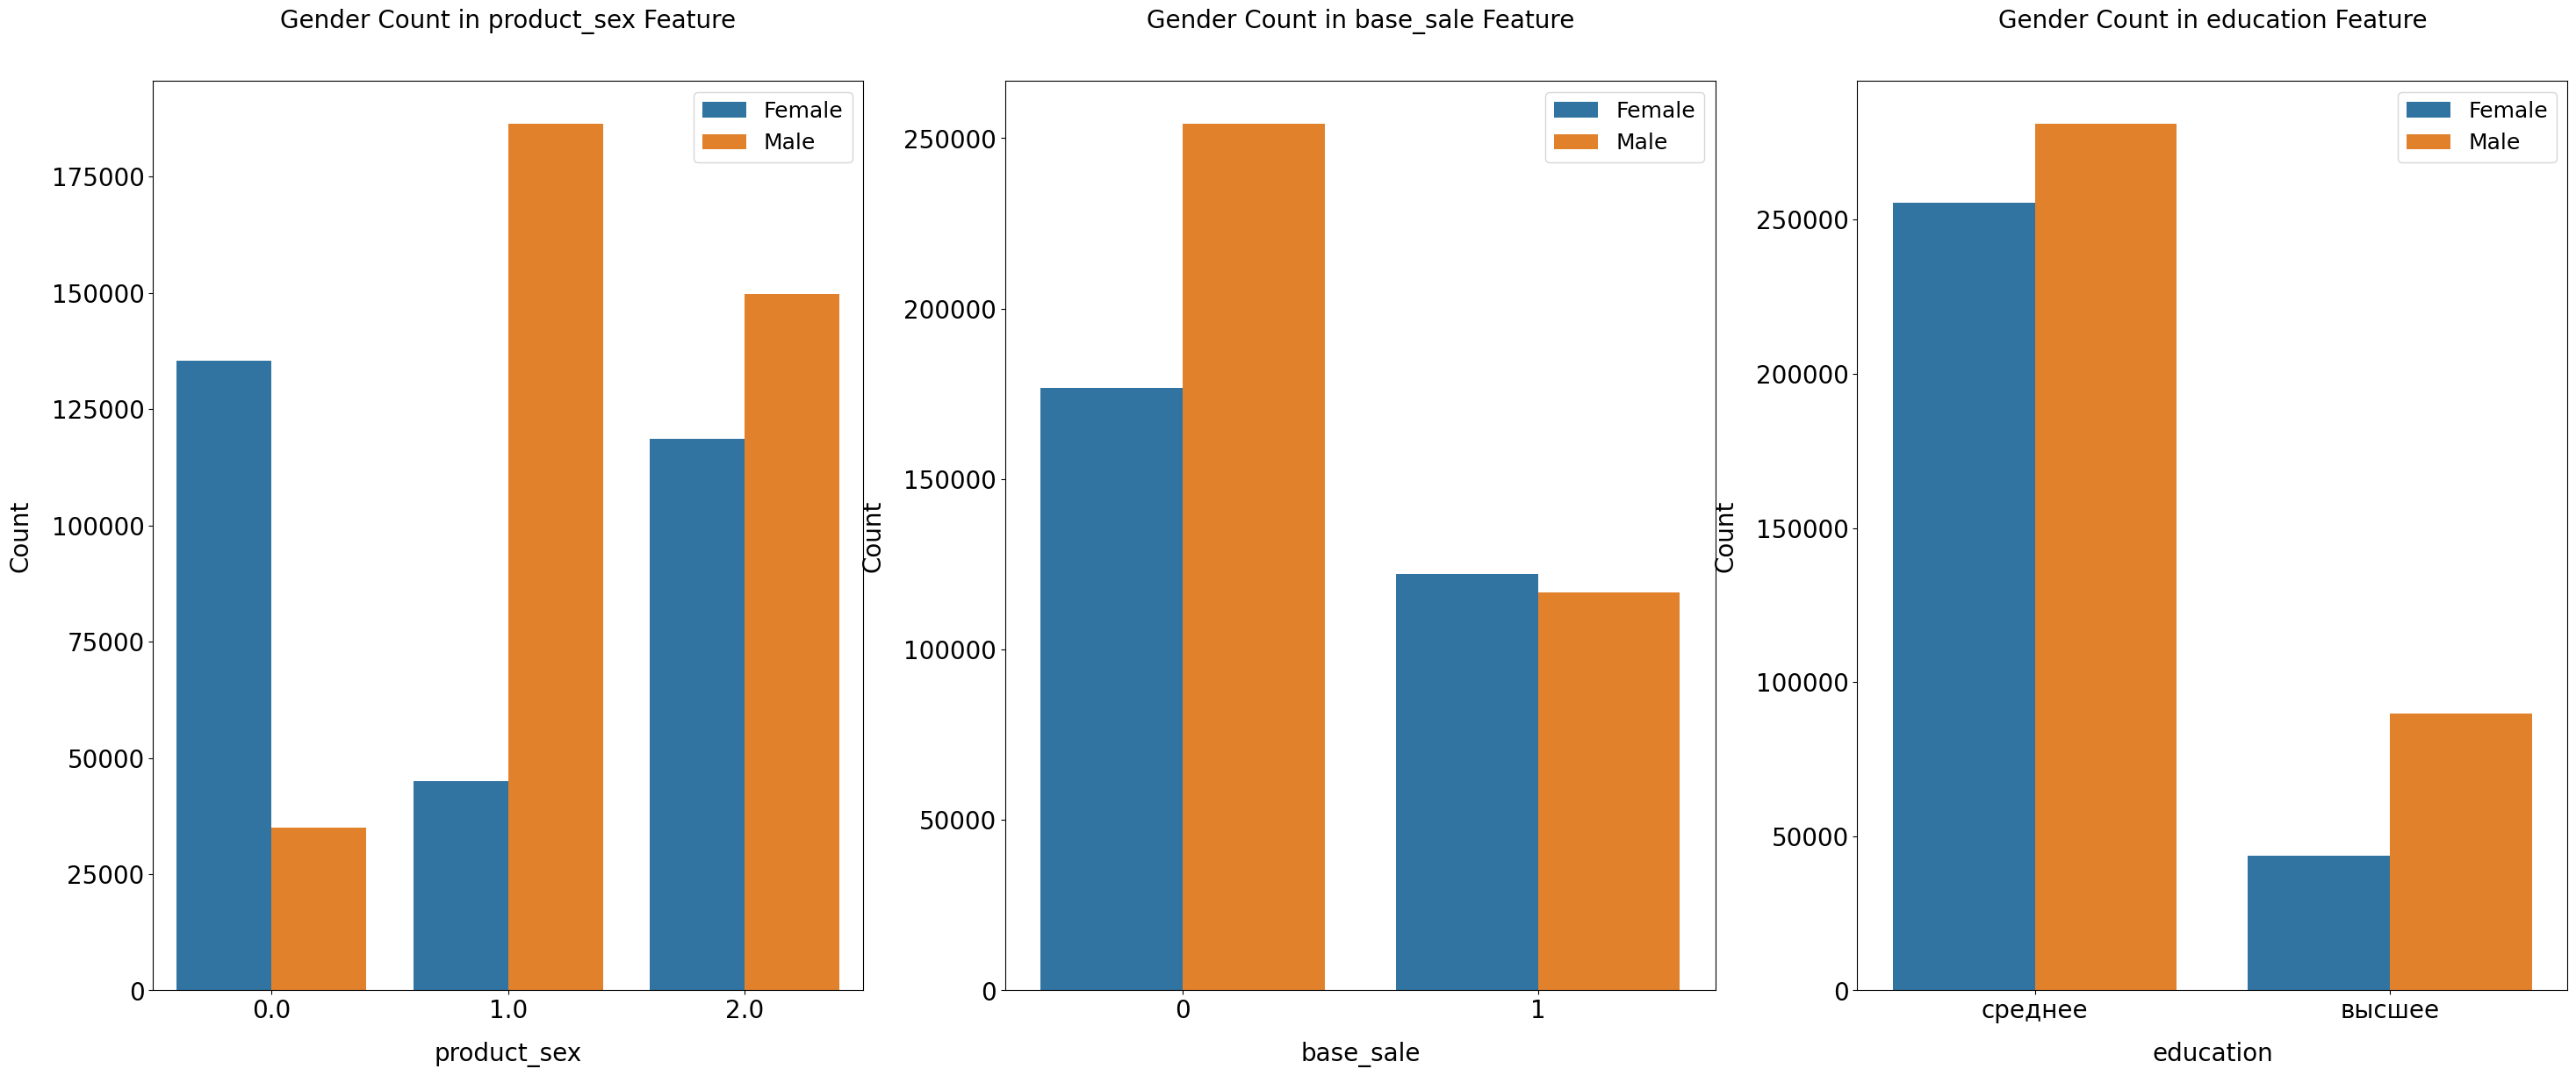

In [17]:
cat_features = ['product_sex', 'base_sale', 'education']

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):    
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, hue='gender', data=df_train)
    
    plt.xlabel('{}'.format(feature), size=20, labelpad=15)
    plt.ylabel('Count', size=20, labelpad=15)    
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    plt.legend(['Female', 'Male'], loc='upper right', prop={'size': 18})
    plt.title('Gender Count in {} Feature'.format(feature), size=20, y=1.05)

plt.show()

# 2. Feature Engineering

## 2.1 Binning Continuous Features

### 2.1.1 Cost

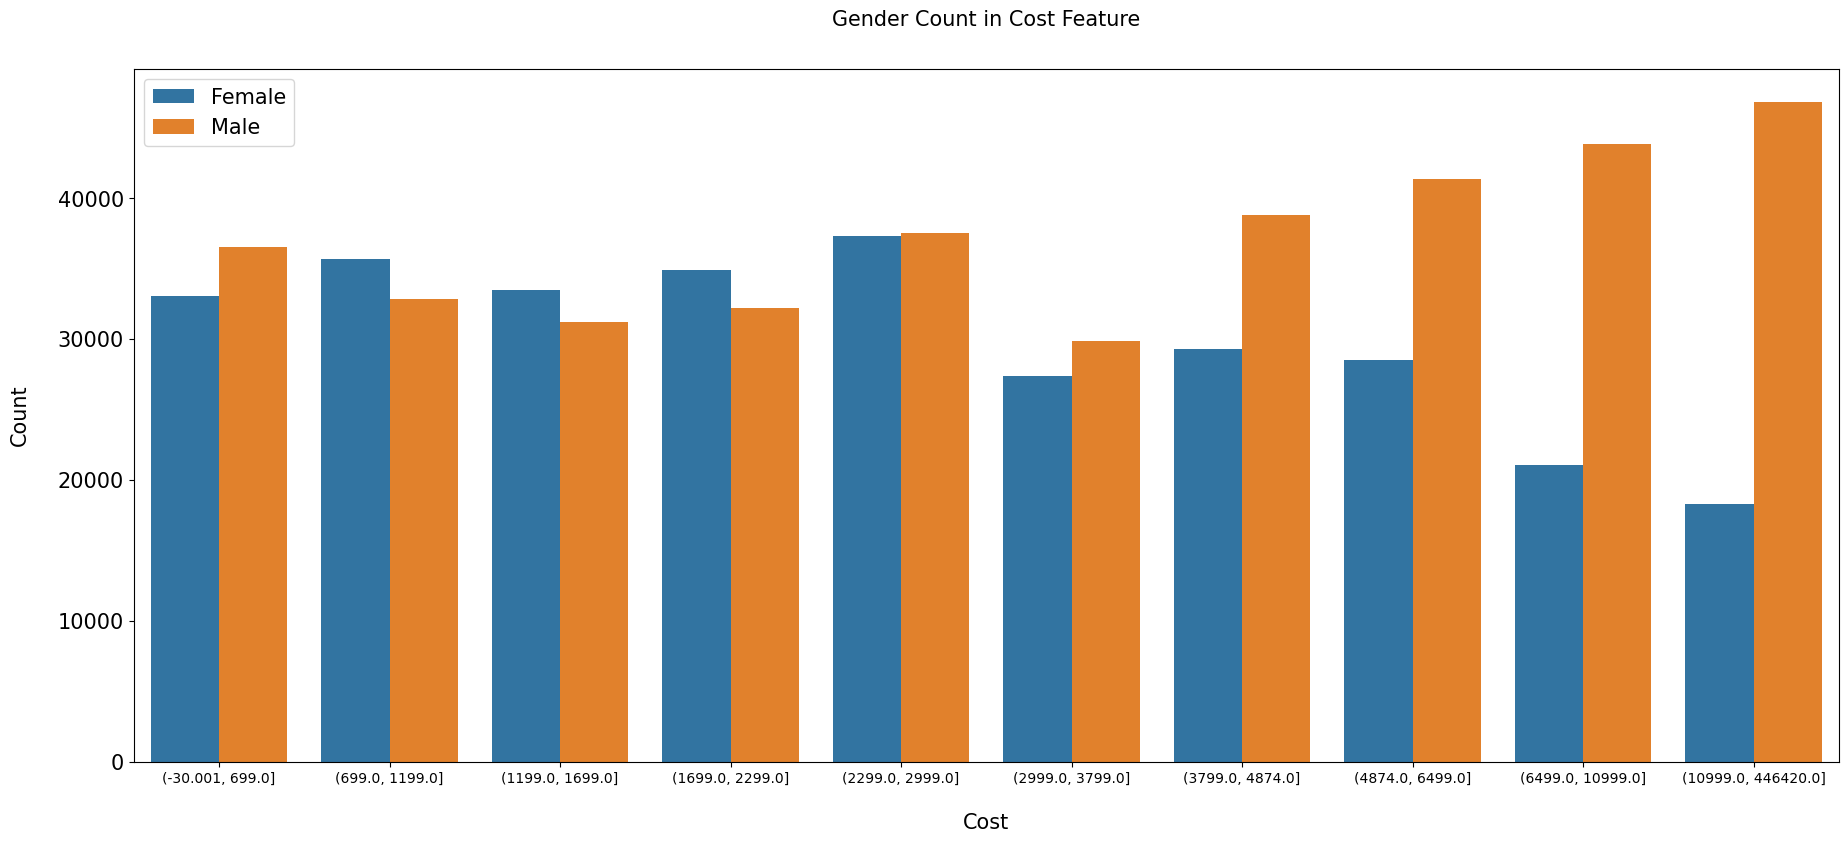

In [18]:
# Bin the cost column
data['cost'] = pd.qcut(data['cost'], 10)

# Plot the distribution of cost
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='cost', hue='gender', data=data)

plt.xlabel('Cost', size=15, labelpad=20)
plt.ylabel('Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Female', 'Male'], loc='upper left', prop={'size': 15})
plt.title('Gender Count in {} Feature'.format('Cost'), size=15, y=1.05)

plt.show()

### 2.1.2 Age

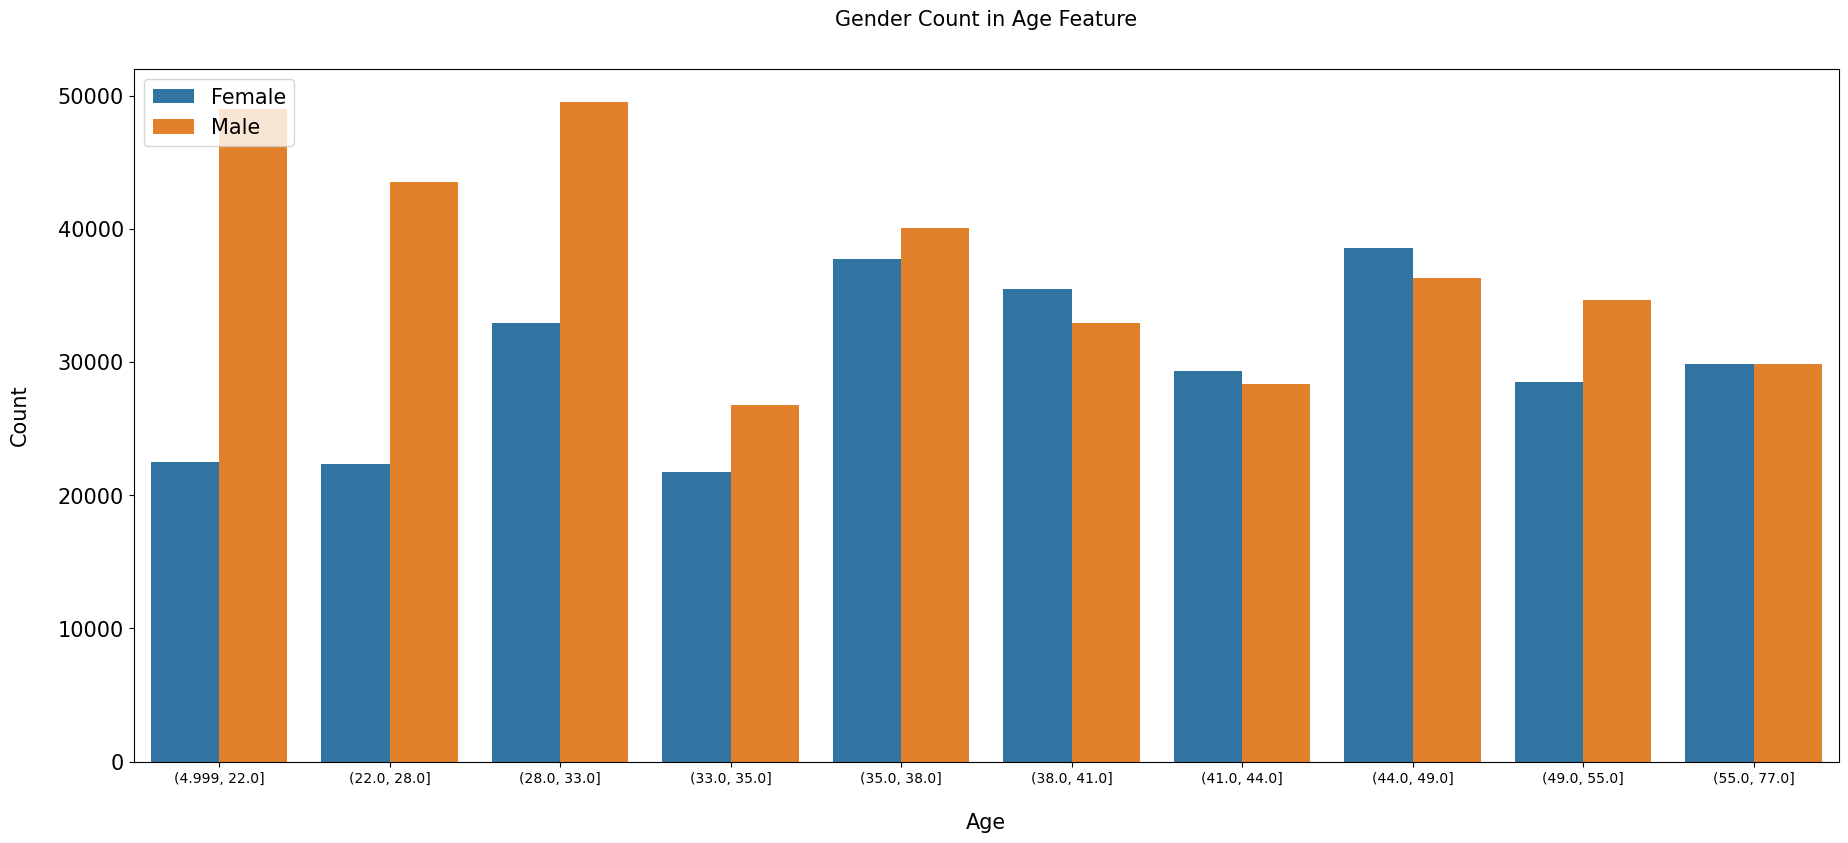

In [19]:
# Bin the age column
data['age'] = pd.qcut(data['age'], 10)

# Plot the distribution of age
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='age', hue='gender', data=data)

plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Female', 'Male'], loc='upper left', prop={'size': 15})
plt.title('Gender Count in {} Feature'.format('Age'), size=15, y=1.05)

plt.show()

### 2.1.3 Product
Column product contains product names. We will extract the product category from the product name.

In [20]:
# Process the product attribute

suffixes = ('ый', 'ие', 'ий', 'ой', 'ее', 'ые', 'ая')

def clean_text(text):
    # Convert to lowercase, remove symbols except Russian letters, and strip spaces
    text = re.sub(r'[^а-я\s]', '', text.lower()).strip()
    # Split into words
    words = text.split()
    # Filter out words with suffixes
    text = ' '.join([word for word in words if not word.endswith(suffixes)])
    # Keep only the first word
    if len(text.split()) > 0:
        text = text.split()[0]
    return text

# Clean the 'product' column
data['product'] = data['product'].apply(clean_text)
data.head()

,id,product,colour,cost,product_sex,base_sale,dt,gender,age,education,city,country,lbt_coef,ac_coef,sm_coef,personal_coef
0,0,велосипед,белый/синий,"(10999.0, 446420.0]",0.0,1,7,0.0,"(35.0, 38.0]",среднее,1201,32,5.078678,-0.307147,0.959027,0.5072
1,0,стол,зелёный,"(1199.0, 1699.0]",2.0,0,37,0.0,"(35.0, 38.0]",среднее,1201,32,5.078678,-0.307147,0.959027,0.5072
2,0,набор,бежевый,"(3799.0, 4874.0]",2.0,0,37,0.0,"(35.0, 38.0]",среднее,1201,32,5.078678,-0.307147,0.959027,0.5072
3,3,бутсы,белый,"(1199.0, 1699.0]",1.0,0,13,NaN,"(28.0, 33.0]",среднее,1134,32,7.764766,-0.030225,0.794720,0.4304
4,3,мяч,мультицвет,"(6499.0, 10999.0]",2.0,0,27,NaN,"(28.0, 33.0]",среднее,1134,32,7.764766,-0.030225,0.794720,0.4304


In [21]:
data['product'].value_counts(normalize=True)[:100]

кроссовки    0.139155
брюки        0.059848
футболка     0.055885
кеды         0.045875
шорты        0.044398
               ...   
гейтор       0.000897
кружка       0.000897
лыжи         0.000890
эспандер     0.000880
горелка      0.000869
Name: product, Length: 100, dtype: float64

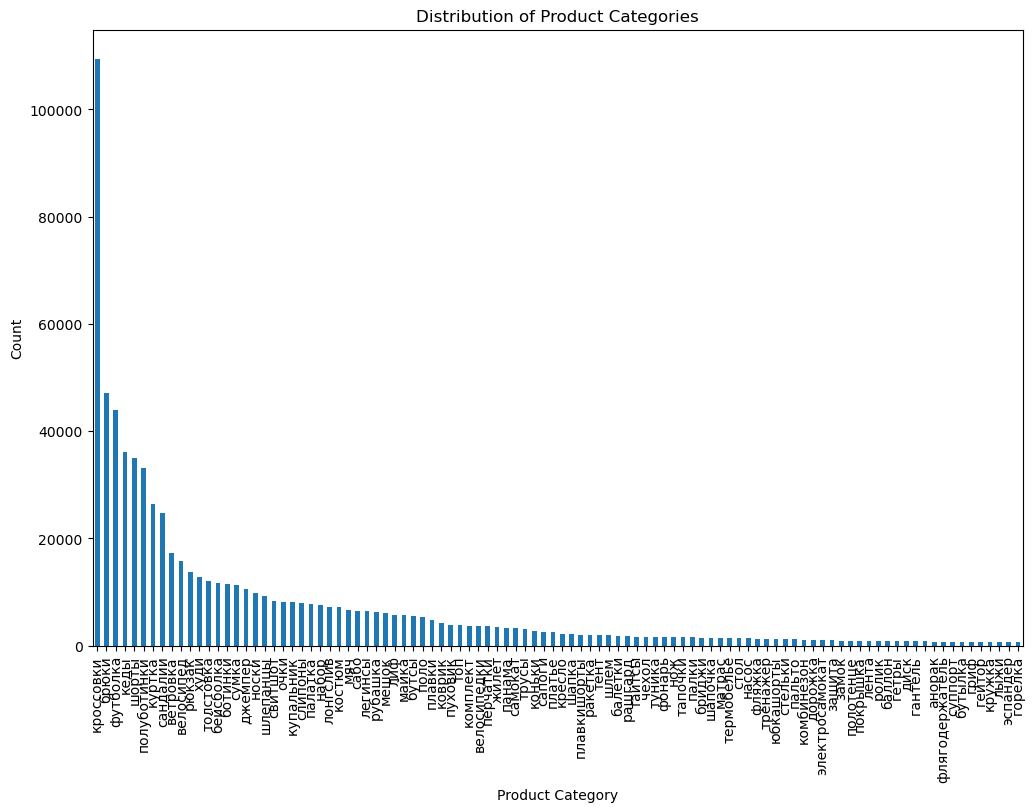

In [22]:
# Plot the distribution of product categories limited to the top 100
plt.figure(figsize=(12, 8))
data['product'].value_counts()[:100].plot(kind='bar')
plt.title('Distribution of Product Categories')
plt.xlabel('Product Category')
plt.ylabel('Count')
plt.show()

### 2.1.4 Colour

In [23]:
# create set of all the colours
colours = set()

for colour in data['colour']:
    for c in colour.split('/'):
        colours.add(c.strip())
print(len(colours))

colours

362


{'BG',
 'BGH',
 'C',
 'CB',
 'CH',
 'DBP',
 'FT',
 'FTGPK',
 'G',
 'GAU',
 'GSU',
 'HPS',
 'HT',
 'HTPK',
 'INC',
 'MBT',
 'PEHL',
 'PEL',
 'PK',
 'PWRT',
 'RBS',
 'ROL',
 'S',
 'SB',
 'TR',
 'cеребряный',
 'Бежевый',
 'Белый',
 'Голубой',
 'Желтый',
 'Зеленый',
 'Коричневый',
 'Красный',
 'Лимонный',
 'Мультицвет',
 'Оранжевый',
 'Разноцветный',
 'Розовый',
 'Серебряный',
 'Серый',
 'Синий',
 'Тёмно-голубой',
 'Фиолетовый',
 'Черный',
 'абрикосовый',
 'авокадо',
 'аквамарин',
 'алый',
 'антрацит',
 'антрацитовый',
 'асфальтовый',
 'бeлый',
 'баклажановый',
 'бежевый',
 'бело-розовый',
 'бело-серый',
 'бело-черный',
 'белый',
 'бесцветный',
 'бирюзово-бежевый',
 'бирюзовый',
 'бледно-белый',
 'бледно-голубой',
 'бледно-зеленый',
 'бледно-мятный',
 'бледно-розовый',
 'бледно-сиреневый',
 'болотный',
 'бордо',
 'бордово-коричневый',
 'бордовый',
 'бронзовый',
 'бургунди',
 'варио',
 'васильковый',
 'вереск',
 'винный',
 'виноградный',
 'вишневый',
 'вишнёвый',
 'водно-зеленый',
 'волна',

Colours column contains abbreviations of colours. We will replace them with full names.

In [24]:
# Create a dictionary of transcripts

transcripts = {
    'FTGPK': 'Фуксия/розовый',
    'PWRT': 'Белый/красный',
    'PEHL': 'Персиковый/хаки/лимонный',
    'HTPK': 'Хаки/розовый',
    'BGH': 'Бежево-серый',
    'DBP': 'Темно-сине-пурпурный',
    'GAU': 'Золотой',
    'GSU': 'Зелено-серебряный',
    'HPS': 'Светло-розовый',
    'INC': 'Индиго',
    'MBT': 'Горчично-коричневый',
    'PEL': 'Бледно-лавандовый',
    'RBS': 'Сине-серебряный',
    'ROL': 'Розово-лиловый',
    'BG':'Бежевый',
    'CB': 'Кобальтово-синий',
    'CH': 'Угольно-черный',
    'SB': 'Небесно-голубой',
    'FT': 'Фуксия',
    'HT': 'Хаки',
    'TR': 'Бирюзовый',
    'PK': 'Розовый',
    'C': 'Голубой',
    'S': 'Серебряный',
    'G': 'Зеленый'
}

# Replace transcripts values with their keys in the dataset
for key, value in transcripts.items():
    data['colour'] = data['colour'].str.replace(key, value)
    

In [25]:
# Replace '-' with '/' split by '/' and lowercase
data['colour'] = data['colour'].str.lower()
data['colour'] = data['colour'].str.replace('-', '/')
data['colour'] = data['colour'].str.split('/')
data.head()

,id,product,colour,cost,product_sex,base_sale,dt,gender,age,education,city,country,lbt_coef,ac_coef,sm_coef,personal_coef
0,0,велосипед,"[белый, синий]","(10999.0, 446420.0]",0.0,1,7,0.0,"(35.0, 38.0]",среднее,1201,32,5.078678,-0.307147,0.959027,0.5072
1,0,стол,[зелёный],"(1199.0, 1699.0]",2.0,0,37,0.0,"(35.0, 38.0]",среднее,1201,32,5.078678,-0.307147,0.959027,0.5072
2,0,набор,[бежевый],"(3799.0, 4874.0]",2.0,0,37,0.0,"(35.0, 38.0]",среднее,1201,32,5.078678,-0.307147,0.959027,0.5072
3,3,бутсы,[белый],"(1199.0, 1699.0]",1.0,0,13,NaN,"(28.0, 33.0]",среднее,1134,32,7.764766,-0.030225,0.794720,0.4304
4,3,мяч,[мультицвет],"(6499.0, 10999.0]",2.0,0,27,NaN,"(28.0, 33.0]",среднее,1134,32,7.764766,-0.030225,0.794720,0.4304


In [26]:
# Create a dictionary of misspelled colours

color_mapping = {
    'антрацит': 'антрацитовый',
    'бeлый': 'белый',
    'винный': 'виноградный',
    'вишнёвый': 'вишневый',
    'графит': 'графитовый',
    'жёлтый': 'желтый',
    'зелёный': 'зеленый',
    'золотистый': 'золотой',
    'ирис': 'ирисовый',
    'яблоко': 'яблочный',
    'хром': 'хромовый',
    'сиинй': 'синий',
    'серовато': 'серый',
    'cеребряный': 'серебряный',
    'серебристый': 'серебряный',
    'серебро': 'серебряный',
    'св.розовый': 'розовый',
    'неопределённый': 'неизвестный',
    'многоцветный': 'цветной',
    'мультицвет': 'цветной',
    'мультиколор': 'цветной',
    'разноцветный': 'цветной',
    'персик': 'персиковый',
    'нюд': 'нюдовый',
    'металлик': 'металлический',
    'леопард': 'леопардовый',
    'лайм': 'лаймовый',
    'коралл': 'коралловый',
    'клетка': 'клетчатый',
    'камуфляж': 'камуфляжный',
    'какао': 'кофейный',
}

# Replace misspelled colors with correct ones
purchases_sp = data.copy()
for i, colour in enumerate(purchases_sp['colour']):
    for j, c in enumerate(colour):
        if c in color_mapping:
            purchases_sp['colour'][i][j] = color_mapping[c]

Now let's cut off the endings.

In [27]:
# Create a stemmer
stemmer = SnowballStemmer('russian')

# Stem words
data['colour'] = data['colour'].apply(lambda x: [stemmer.stem(y) for y in x])

data.head()

,id,product,colour,cost,product_sex,base_sale,dt,gender,age,education,city,country,lbt_coef,ac_coef,sm_coef,personal_coef
0,0,велосипед,"[бел, син]","(10999.0, 446420.0]",0.0,1,7,0.0,"(35.0, 38.0]",среднее,1201,32,5.078678,-0.307147,0.959027,0.5072
1,0,стол,[зелен],"(1199.0, 1699.0]",2.0,0,37,0.0,"(35.0, 38.0]",среднее,1201,32,5.078678,-0.307147,0.959027,0.5072
2,0,набор,[бежев],"(3799.0, 4874.0]",2.0,0,37,0.0,"(35.0, 38.0]",среднее,1201,32,5.078678,-0.307147,0.959027,0.5072
3,3,бутсы,[бел],"(1199.0, 1699.0]",1.0,0,13,NaN,"(28.0, 33.0]",среднее,1134,32,7.764766,-0.030225,0.794720,0.4304
4,3,мяч,[цветн],"(6499.0, 10999.0]",2.0,0,27,NaN,"(28.0, 33.0]",среднее,1134,32,7.764766,-0.030225,0.794720,0.4304


In [28]:
# Let's look at the result
colours = set()

for colour in data['colour']:
    for c in colour:
        colours.add(c)
print(len(colours))

colours

166


{'абрикосов',
 'авокад',
 'аквамарин',
 'ал',
 'антрацитов',
 'асфальтов',
 'баклажанов',
 'бежев',
 'бел',
 'бесцветн',
 'бирюзов',
 'бледн',
 'болотн',
 'борд',
 'бордов',
 'бронзов',
 'бургунд',
 'вар',
 'васильков',
 'вереск',
 'виноградн',
 'вишнев',
 'водн',
 'волн',
 'вольт',
 'глинян',
 'глянцев',
 'голуб',
 'горчичн',
 'гранитн',
 'графитов',
 'грязн',
 'да',
 'дерев',
 'джунгл',
 'дымчат',
 'ежевичн',
 'елов',
 'желт',
 'жемчужн',
 'зебр',
 'зел',
 'зелен',
 'зеркальн',
 'золот',
 'изумрудн',
 'индиг',
 'ирисов',
 'кам',
 'камуфляжн',
 'карбон',
 'каштанов',
 'кедров',
 'кирпичн',
 'кислотн',
 'клетчат',
 'клубник',
 'кобальтов',
 'кораллов',
 'коричнев',
 'кост',
 'кофейн',
 'красн',
 'кремов',
 'кукурузн',
 'лавандов',
 'лазурн',
 'лаймов',
 'латт',
 'латун',
 'леопардов',
 'лилов',
 'лимон',
 'лососев',
 'льнян',
 'маджент',
 'малахитов',
 'малинов',
 'манг',
 'масля',
 'матов',
 'медн',
 'медов',
 'мел',
 'меланж',
 'ментол',
 'металлическ',
 'милитар',
 'молочн',
 'морко

We've cut the number of unique colors in half!

### 2.1.5 Product_sex 
We will create new features that will tell us whether the product's sex is male, female, or genderless.

In [29]:

def create_product_sex_features(df):
    # Create a dictionary to map product_sex values to their corresponding feature names
    sex_mapping = {0: 'female', 1: 'male', 2: 'genderless'}

    # Iterate through each unique value in the 'product_sex' column
    for sex_value in df['product_sex'].unique():
        # Create a new column with a boolean flag for the specific product_sex value
        column_name = f'product_sex_{sex_mapping[sex_value]}'
        df[column_name] = (df['product_sex'] == sex_value).astype(int)

    # Drop the original 'product_sex' column
    df.drop('product_sex', axis=1, inplace=True)

    return df

# Call the function to create features
data = create_product_sex_features(data)
data.head()

,id,product,colour,cost,base_sale,dt,gender,age,education,city,country,lbt_coef,ac_coef,sm_coef,personal_coef,product_sex_female,product_sex_genderless,product_sex_male
0,0,велосипед,"[бел, син]","(10999.0, 446420.0]",1,7,0.0,"(35.0, 38.0]",среднее,1201,32,5.078678,-0.307147,0.959027,0.5072,1,0,0
1,0,стол,[зелен],"(1199.0, 1699.0]",0,37,0.0,"(35.0, 38.0]",среднее,1201,32,5.078678,-0.307147,0.959027,0.5072,0,1,0
2,0,набор,[бежев],"(3799.0, 4874.0]",0,37,0.0,"(35.0, 38.0]",среднее,1201,32,5.078678,-0.307147,0.959027,0.5072,0,1,0
3,3,бутсы,[бел],"(1199.0, 1699.0]",0,13,NaN,"(28.0, 33.0]",среднее,1134,32,7.764766,-0.030225,0.794720,0.4304,0,0,1
4,3,мяч,[цветн],"(6499.0, 10999.0]",0,27,NaN,"(28.0, 33.0]",среднее,1134,32,7.764766,-0.030225,0.794720,0.4304,0,1,0


## 2.2 Feature Transformation

### 2.2.1 Label Encoding

In [30]:
features = ['cost', 'age', 'education']

for feature in features:        
    data[feature] = LabelEncoder().fit_transform(data[feature])

data.head()

,id,product,colour,cost,base_sale,dt,gender,age,education,city,country,lbt_coef,ac_coef,sm_coef,personal_coef,product_sex_female,product_sex_genderless,product_sex_male
0,0,велосипед,"[бел, син]",9,1,7,0.0,4,1,1201,32,5.078678,-0.307147,0.959027,0.5072,1,0,0
1,0,стол,[зелен],2,0,37,0.0,4,1,1201,32,5.078678,-0.307147,0.959027,0.5072,0,1,0
2,0,набор,[бежев],6,0,37,0.0,4,1,1201,32,5.078678,-0.307147,0.959027,0.5072,0,1,0
3,3,бутсы,[бел],2,0,13,NaN,2,1,1134,32,7.764766,-0.030225,0.794720,0.4304,0,0,1
4,3,мяч,[цветн],8,0,27,NaN,2,1,1134,32,7.764766,-0.030225,0.794720,0.4304,0,1,0


## 

# 3. Model

In [31]:
# Drop unnecessary columns
drop_cols = ['id', 'city', 'country', 'product', 'colour', 'ac_coef']
model_data = data.drop(drop_cols, axis=1)

In [32]:
# Divide the data
df_train, df_test = divide_df(model_data)

ignore = ['lbt_coef', 'sm_coef', 'personal_coef', 'gender']
features = [c for c in df_train.columns if c not in ignore]

# Standardize the data except coefs
scaler = StandardScaler()
df_train[features] = scaler.fit_transform(df_train[features])
df_test[features] = scaler.transform(df_test[features])

# Split the data
X_train = df_train[df_train.drop('gender', axis=1).columns]
y_train = df_train['gender'].values
X_test = df_test[df_test.drop('gender', axis=1).columns]

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (669956, 11)
y_train shape: (669956,)
X_test shape: (116304, 11)


## 3.1 Random Forest

In [34]:
random_forest = RandomForestClassifier(n_estimators=100, oob_score = True)
random_forest.fit(X_train, y_train)
Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, y_train)

acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
print(round(acc_random_forest,2,), "%")

100.0 %


In [35]:
print("oob score:", round(random_forest.oob_score_, 4)*100, "%")

oob score: 100.0 %


## 3.2 Feature Importance

In [36]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
importances.head(15)

,importance
feature,
lbt_coef,0.500
personal_coef,0.415
product_sex_female,0.041
product_sex_male,0.025
sm_coef,0.009
product_sex_genderless,0.004
age,0.003
cost,0.002
education,0.001


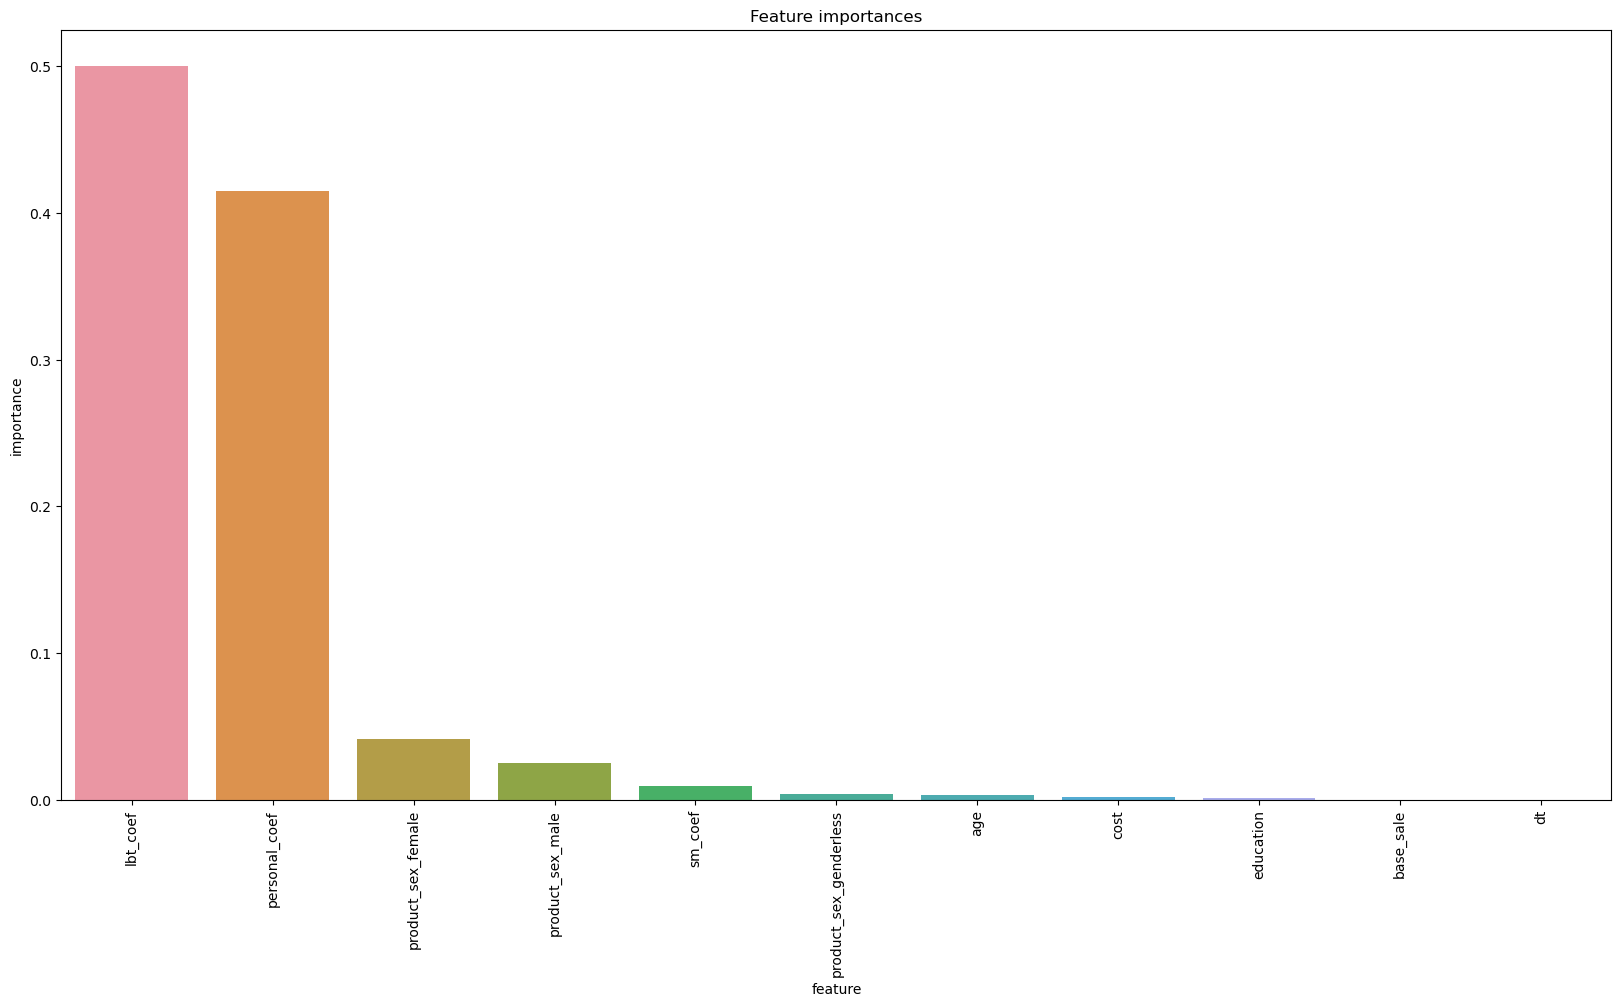

In [37]:
# Plot the feature importances of the forest
plt.figure(figsize=(20, 10))
plt.title("Feature importances")
sns.barplot(x=importances.index, y=importances['importance'])
plt.xticks(rotation=90)
plt.show()

In [38]:
# Leave only the most important features
best_features = importances[importances['importance'] > 0.001].index

X_train = X_train[best_features]
X_test = X_test[best_features]

## 3.3 Test new paramters

In [39]:
# Random Forest
random_forest = RandomForestClassifier(criterion = "gini", 
                                       min_samples_leaf = 1, 
                                       min_samples_split = 10,   
                                       n_estimators=100, 
                                       max_features='auto', 
                                       oob_score=True, 
                                       random_state=1, 
                                       n_jobs=-1)

random_forest.fit(X_train, y_train)
Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, y_train)

print("oob score:", round(random_forest.oob_score_, 4)*100, "%")

oob score: 100.0 %


## 3.4 Further Evaluation

### 3.4.1 Confusion Matrix

In [40]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
predictions = cross_val_predict(random_forest, X_train, y_train, cv=3)
confusion_matrix(y_train, predictions)

array([[299000,      0],
       [     0, 370956]], dtype=int64)

### 3.4.2 Precision and Recall

In [41]:
from sklearn.metrics import precision_score, recall_score

print("Precision:", precision_score(y_train, predictions))
print("Recall:",recall_score(y_train, predictions))

Precision: 1.0
Recall: 1.0


### 3.4.3 F-Score

In [42]:
from sklearn.metrics import f1_score
f1_score(y_train, predictions)

1.0

### 3.4.4 Precision Recall Curve

In [43]:
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores = random_forest.predict_proba(X_train)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(y_train, y_scores)

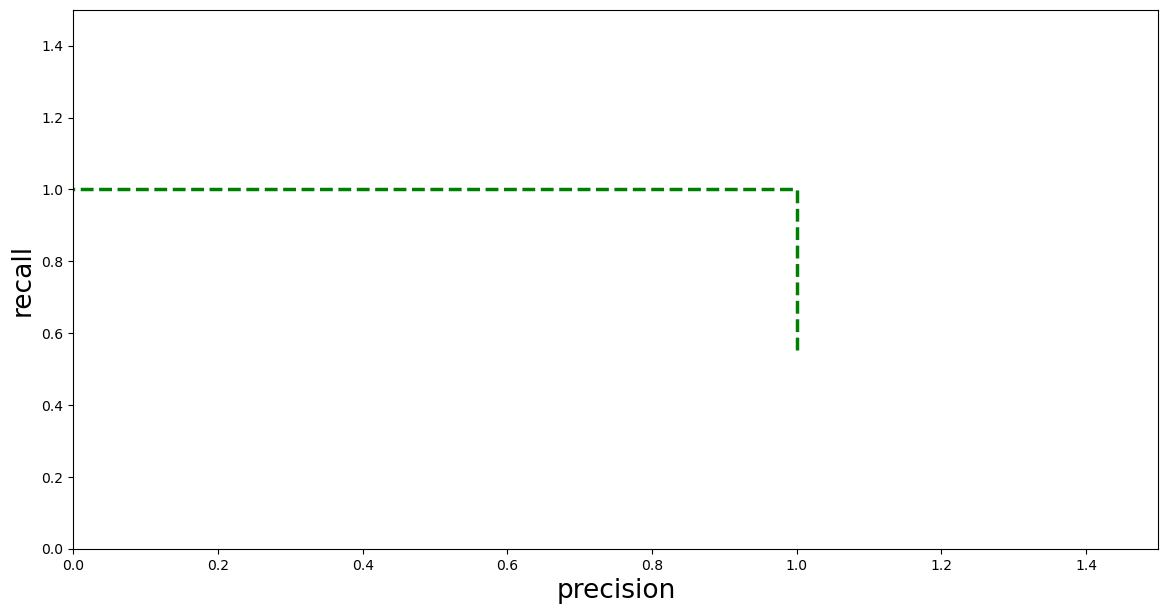

In [44]:
def plot_precision_vs_recall(precision, recall):
    plt.plot(recall, precision, "g--", linewidth=2.5)
    plt.ylabel("recall", fontsize=19)
    plt.xlabel("precision", fontsize=19)
    plt.axis([0, 1.5, 0, 1.5])

plt.figure(figsize=(14, 7))
plot_precision_vs_recall(precision, recall)
plt.show()

### 3.4.5 ROC AUC Curve

In [45]:
from sklearn.metrics import roc_curve
# compute true positive rate and false positive rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, y_scores)

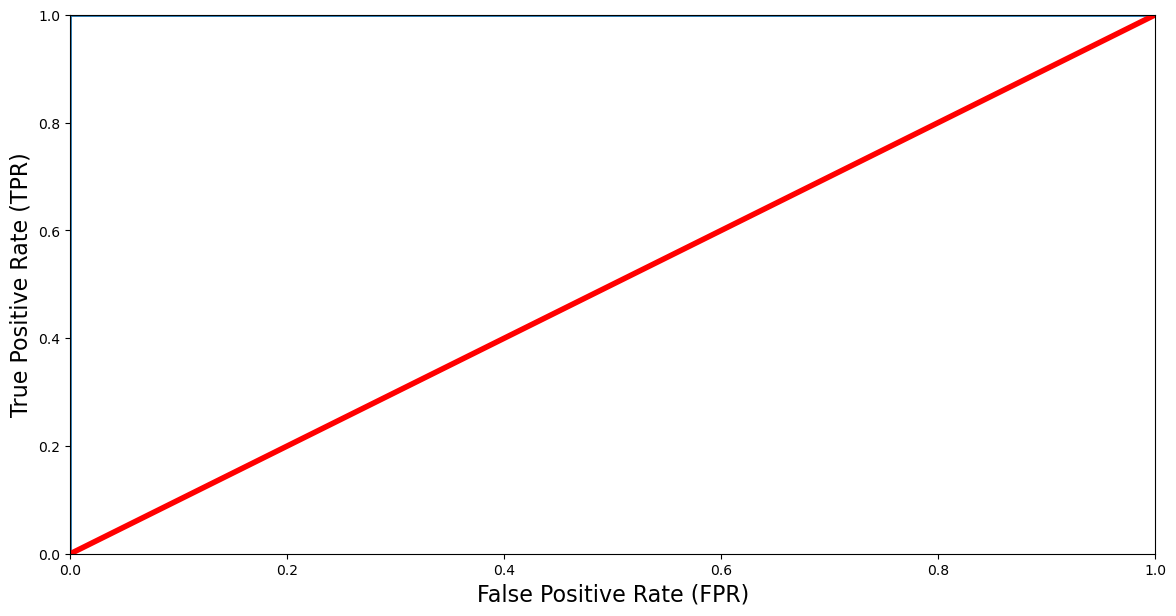

In [46]:
# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

## 3.5 Submission

In [50]:
# Fill in the missing values with the predicted values
data.loc[data['gender'].isnull(), 'gender'] = Y_prediction
data.info()

,id,product,colour,cost,base_sale,dt,gender,age,education,city,country,lbt_coef,ac_coef,sm_coef,personal_coef,product_sex_female,product_sex_genderless,product_sex_male
0,0,велосипед,"[бел, син]",9,1,7,0.0,4,1,1201,32,5.078678,-0.307147,0.959027,0.5072,1,0,0
1,0,стол,[зелен],2,0,37,0.0,4,1,1201,32,5.078678,-0.307147,0.959027,0.5072,0,1,0
2,0,набор,[бежев],6,0,37,0.0,4,1,1201,32,5.078678,-0.307147,0.959027,0.5072,0,1,0
3,3,бутсы,[бел],2,0,13,1.0,2,1,1134,32,7.764766,-0.030225,0.794720,0.4304,0,0,1
4,3,мяч,[цветн],8,0,27,1.0,2,1,1134,32,7.764766,-0.030225,0.794720,0.4304,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786255,178004,полуботинки,"[хак, черн]",8,0,12,1.0,8,0,1188,32,8.437832,-0.080251,0.938592,0.4688,0,0,1
786256,178004,кроссовки,"[черн, сер]",9,0,13,1.0,8,0,1188,32,8.437832,-0.080251,0.938592,0.4688,0,0,1
786257,178004,кроссовки,"[черн, сер]",9,0,20,1.0,8,0,1188,32,8.437832,-0.080251,0.938592,0.4688,0,0,1
786258,178004,пакет,[коричнев],0,0,20,1.0,8,0,1188,32,8.437832,-0.080251,0.938592,0.4688,0,1,0


In [52]:
# Save the data
data.to_csv('data/data.csv', index=False)